# House Prices Prediction (regression)

#### References
* Tutorial: https://towardsdatascience.com/machine-learning-with-python-regression-complete-tutorial-47268e546cea 
* Dataset: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

### Importing Libraries

In [5]:
# for data
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

# for machine learning
from sklearn import model_selection, preprocessing, feature_extraction, feature_selection, ensemble, linear_model, metrics, decomposition

# for explainer
from lime import lime_tabular

### Read data into pandas data frame

In [6]:
dtf = pd.read_csv("hp_data/train.csv")

cols = ["OverallQual","GrLivArea","GarageCars", 
        "GarageArea","TotalBsmtSF","FullBath",
        "YearBuilt","YearRemodAdd",
        "LotFrontage","MSSubClass"]

dtf = dtf[["Id"]+cols+["SalePrice"]]
dtf.head()

,Id,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass,SalePrice
0,1,7,1710,2,548,856,2,2003,2003,65.0,60,208500
1,2,6,1262,2,460,1262,2,1976,1976,80.0,20,181500
2,3,7,1786,2,608,920,2,2001,2002,68.0,60,223500
3,4,7,1717,3,642,756,1,1915,1970,60.0,70,140000
4,5,8,2198,3,836,1145,2,2000,2000,84.0,60,250000


### Data Analysis: EDA

I always start by getting an overview of the whole dataset, in particular, I want to know how many categorical and numerical variables there are and the proportion of missing data. Recognizing a variable’s type sometimes can be tricky because categories can be expressed as numbers. To this end, I am going to write a simple function that will do that for us:

In [7]:
'''
Recognize whether a column is numerical or categorical.
:parameter
    :param dtf: dataframe - input data
    :param col: str - name of the column to analyze
    :param max_cat: num - max number of unique values to recognize a column as categorical
:return
    "cat" if the column is categorical or "num" otherwise
'''

def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

In [8]:
# plot a heatmap of the dataframe and visualize columns type and missing data.

dic_cols = {col:utils_recognize_type(dtf, col, max_cat=20) for col in dtf.columns}

In [9]:
dic_cols

{'Id': 'num',
 'OverallQual': 'cat',
 'GrLivArea': 'num',
 'GarageCars': 'cat',
 'GarageArea': 'num',
 'TotalBsmtSF': 'num',
 'FullBath': 'cat',
 'YearBuilt': 'num',
 'YearRemodAdd': 'num',
 'LotFrontage': 'num',
 'MSSubClass': 'cat',
 'SalePrice': 'num'}

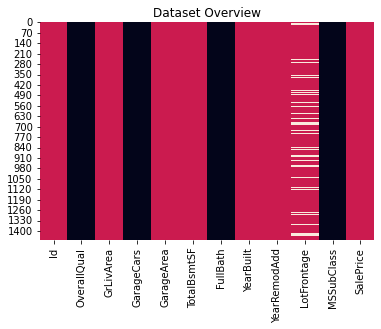

 Categerocial   Numeric   NaN 


In [10]:
heatmap = dtf.isnull()

for k,v in dic_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)

sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

#### Analysis:

There are 1460 rows and 12 columns:
* each row of the table represents a specific house (or observation) identified by Id, so I’ll set it as the index (or primary key of the table for SQL lovers).
* SalePrice is the dependent variable that we want to understand and predict, so I’ll rename the column “Y”.
* OverallQuall, GarageCars, FullBath and MSSubClass are categorical variables while the others are numerical.
* Only LotFrontage contains missing data.

In [11]:
dtf = dtf.set_index("Id")
dtf = dtf.rename(columns={"SalePrice":"Y"})

First, let’s have a look at the univariate distributions (probability distribution of just one variable). A *histogram* is perfect to give a rough sense of the density of the underlying distribution of a single numerical data. I recommend using a *box plot* to graphically depict data groups through their quartiles.

In [ ]:
x = "Y"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)
### distribution
ax[0].title.set_text('distribution')
variable = dtf[x].fillna(dtf[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = dtf[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(dtf[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
plt.show()